# Electricity Dataset EDA

[Electricity](https://www.openml.org/d/151) is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers
- [Link](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=941C4F797CE7E263E979FA38DE90840F?doi=10.1.1.12.9405&rep=rep1&type=pdf) M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.
    - **NOTE** - this is the dataset paper and has really good descriptions of why this dataset is strong for modeling drifting concepts
- [Link](https://www.researchgate.net/publication/220974771_Learning_with_Drift_Detection) J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

## Why is this dataset good/bad for exploring Concept Drift?


**Good:**
- Shared benchmark between Nisha and I's approaches + standard dataset in concept drift detection world
- The data here is based on electricity markets in Australian state of NSW. This market was privatized on May 11, 1996 (i.e. start of this dataset). As this dataset begins when the electricity market first opened, we can expect the behavior of participants to become more sophisticated over time, leading to changes in the aggregate market behavior.
- In addition, on May 4, 1997, the electricity market in neighboring state of Victoria was linked to the NSW market - allowing oversupply in one market to be sold interstate - which provided a dampeneron some extreme price movements (and likely equates to a change in concept)
- Electricity prices are affected by supply and demand. Some major influences ond demand being season, weather, time of day, central business district population density.
- Primary influency on supply is number of electricity generators onlin - aka this domain is known to exhibit substantial seasonality and sensitivity to short term events such as weather fluctuations. (not sure if this makes a good dataset to use...)

**Bad:**
- It's not the best demonstration of label scarcity or verification latentcy since ground truth labels are readily obtained every 30 minutes


**Other Thoughts:**
- Elec2 is an extension of Elec1 - where initially the following features were available for 1 year of NSW data: date, day of week, time, class label. 
- So to remain consistent with features that were available at the time of, we should really only use those features that were available throughout (day, time, NSW demand)
- PRICE DATA SHOULD BE IGNORED COMPLETELY as NSWprice is used to derive the target class and Vic price can't be known at the same timestep
- Both demand features (`VICdemand` and `NSWdemand`) are ACTUAL values of demand for that timepoint, and therefore contribute to target leakage.... authors include them "as a proxy for projections of attribute demand that might be used instead. These attributes should be very relevant to price as the price setting mechanism combines electricity demand with the price schedules published by power generator suppliers"

**Summary:**

If we want to use this dataset, we need to:
- Only use 3 features: day of week, time of day, NSWdemand (aka "projected demand") to predict the class = NSW price is higher/lower than the running 24 hour average.
- Using such a simple dataset will be GREAT for initial experimentation
- There are known macro and micro concept drifts that should occur

**Open Questions:**
- Should time of day be categorical or continuous?
- Should we time difference the VICdemand so that its stationary???
- Should we do other feature engineering - lag variables, date features, etc?
- Would it be good to include the other variables (VICdemand, Scheduled Elec Transfer) that only become available after a year - as this could be a proxy for changing data distribution?... sounds too complicated 
- How to choose window size?


In [4]:
!which python3

/Users/areed/Documents/research/FF22_concept_drift/concept-drift/.venv/bin/python3


In [310]:
%load_ext nb_black

import sys

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [384]:
data = pd.read_csv("../data/electricity-normalized.csv")

<IPython.core.display.Javascript object>

In [385]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  int64  
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   class      45312 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 3.1+ MB


<IPython.core.display.Javascript object>

In [386]:
data.describe()

date           day        period      nswprice     nswdemand  \
count  45312.000000  45312.000000  45312.000000  45312.000000  45312.000000   
mean       0.499080      4.003178      0.500000      0.057868      0.425418   
std        0.340308      1.998695      0.294756      0.039991      0.163323   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.031934      2.000000      0.250000      0.035127      0.309134   
50%        0.456329      4.000000      0.500000      0.048652      0.443693   
75%        0.880547      6.000000      0.750000      0.074336      0.536001   
max        1.000000      7.000000      1.000000      1.000000      1.000000   

           vicprice     vicdemand      transfer  
count  45312.000000  45312.000000  45312.000000  
mean       0.003467      0.422915      0.500526  
std        0.010213      0.120965      0.153373  
min        0.000000      0.000000      0.000000  
25%        0.002277      0.372346      0.414912  
50%        0.003467      0.422915      0.414912  
75%        0.003467      0.469252      0.605702  
max        1.000000      1.000000      1.000000

<IPython.core.display.Javascript object>

In [387]:
data.head()

date  day    period  nswprice  nswdemand  vicprice  vicdemand  transfer  \
0   0.0    2  0.000000  0.056443   0.439155  0.003467   0.422915  0.414912   
1   0.0    2  0.021277  0.051699   0.415055  0.003467   0.422915  0.414912   
2   0.0    2  0.042553  0.051489   0.385004  0.003467   0.422915  0.414912   
3   0.0    2  0.063830  0.045485   0.314639  0.003467   0.422915  0.414912   
4   0.0    2  0.085106  0.042482   0.251116  0.003467   0.422915  0.414912   

  class  
0    UP  
1    UP  
2    UP  
3    UP  
4  DOWN

<IPython.core.display.Javascript object>

## Inspect Features

In [397]:
fig = px.line(data_frame=data[["vicdemand", "nswdemand"]])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

<IPython.core.display.Javascript object>

### `Date` Field

<AxesSubplot:>

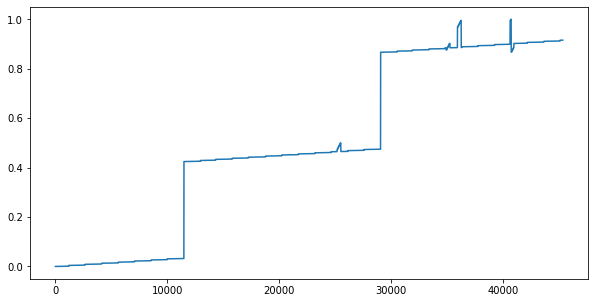

<IPython.core.display.Javascript object>

In [19]:
data.date.plot(figsize=(10, 5))

- This plot doesn't make sense to me... I would expect the date field to increase linearly throughout full dataset...
- Might need to fix this field by hardcoding it to the correspoinding dates and times

### `Day` Field

<AxesSubplot:>

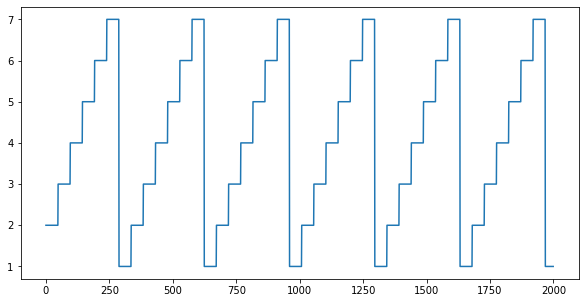

<IPython.core.display.Javascript object>

In [20]:
data.day[:2000].plot(figsize=(10, 5))

- Need to manually lookup which day of week maps to which categorical integer..?
- ANSWER: First day of dataset (day = 2) is May 7th, 1996 which is a Tuesday --> 0 = Sunday

### `Period` Field

<AxesSubplot:>

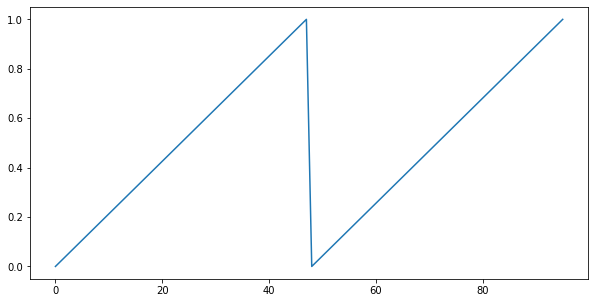

<IPython.core.display.Javascript object>

In [21]:
data.period[: 48 * 2].plot(figsize=(10, 5))

- Two full days == 96 observations

### `NSWdemand` Field

<AxesSubplot:>

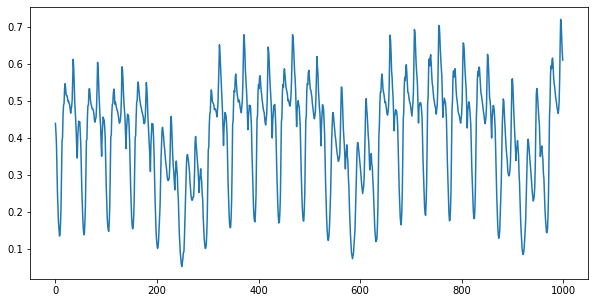

<IPython.core.display.Javascript object>

In [356]:
data.nswdemand[:1000].plot(figsize=(10, 5))

- **TO-DO** - this is data is non-stationary and cyclic. Need to apply differencing to make stationary??

In [23]:
data.nswdemand.shape

(45312,)

<IPython.core.display.Javascript object>

<AxesSubplot:>

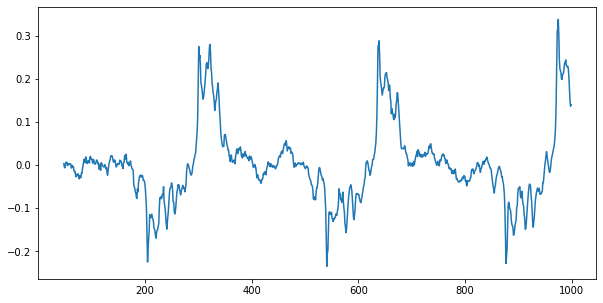

<IPython.core.display.Javascript object>

In [358]:
# remove daily seasonality
demand_diff = data.nswdemand.diff(48)  # 1 day = 48 steps
demand_diff[:1000].plot(figsize=(10, 5))

- Now we have weekly seasonality ^

<AxesSubplot:>

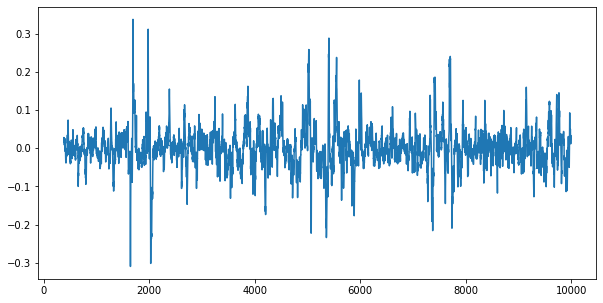

<IPython.core.display.Javascript object>

In [368]:
demand_diff_week_removed = demand_diff.diff(48 * 7)
demand_diff_week_removed[:10000].plot(figsize=(10, 5))

- Now we have monthy?

In [367]:
fig = px.line(data_frame=demand_diff_week_removed.diff(48 * 30))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

<IPython.core.display.Javascript object>

# TO ADD TO NOTION
- Time component but not time series
- Handle trend and seasonality

### `NSWprice` Field

<AxesSubplot:>

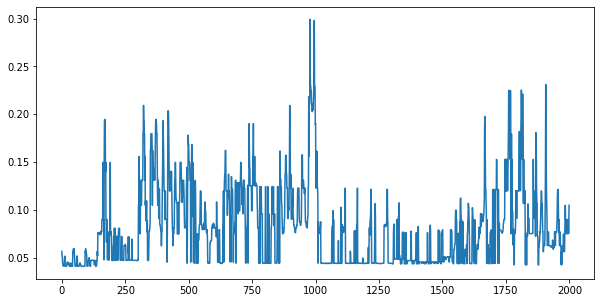

<IPython.core.display.Javascript object>

In [25]:
data.nswprice[:2000].plot(figsize=(10, 5))

### `VICdemand` Field

<AxesSubplot:>

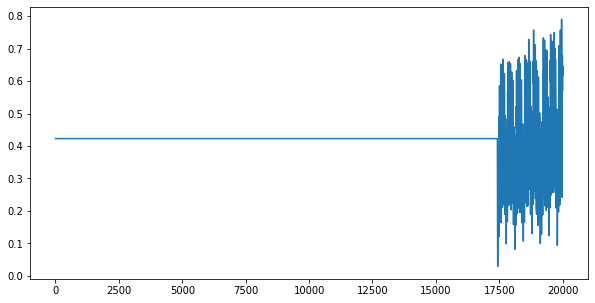

<IPython.core.display.Javascript object>

In [26]:
data.vicdemand[:20000].plot(figsize=(10, 5))

- Victoria demand is constant at ~0.42 for the first 17500 observations (this equates to the first full YEAR of data)???

### `VICprice` Field

<AxesSubplot:>

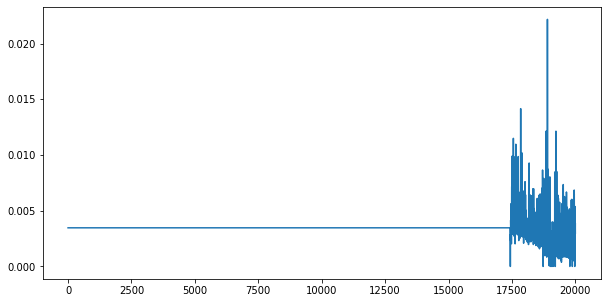

<IPython.core.display.Javascript object>

In [27]:
data.vicprice[:20000].plot(figsize=(10, 5))

- Same with price

### `transfer` Field

<AxesSubplot:>

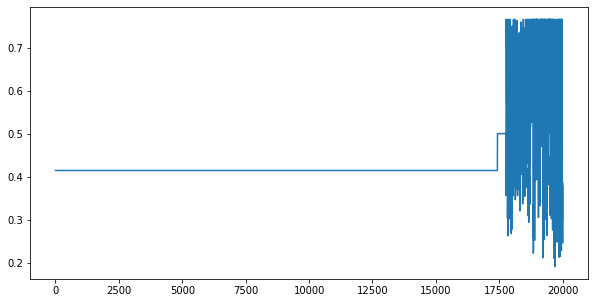

<IPython.core.display.Javascript object>

In [28]:
data.transfer[:20000].plot(figsize=(10, 5))

### `class` Field

<AxesSubplot:>

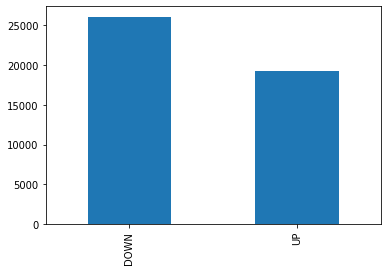

<IPython.core.display.Javascript object>

In [29]:
data["class"].value_counts().plot(kind="bar")

## Clean Data

- Drop all features other than:
    - `day` (of week)
    - `period` (time of day)
    - `nswdemand` 
    - `class`
    
- label encode categorical
- specify dtypes
- normalize

In [30]:
# specify columns to keep and if categorical
cols = (("day", True), ("period", True), ("nswdemand", False), ("class", True))

data_clean = data[[col for col, _ in cols]].copy(deep=True)

# label encode categorical
catcols = (col for col, iscat in cols if iscat)

for col in catcols:
    data_clean[col] = LabelEncoder().fit_transform(data_clean[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


data_clean = categorize(data_clean, cols)

# normalize all
# data_clean = MinMaxScaler().fit_transform(data_clean)

# split data from labels
def split_df(df, label_col):
    return df.drop(label_col, axis=1), df[label_col]


data, labels = split_df(data_clean, "class")

<IPython.core.display.Javascript object>

In [375]:
data_clean

day period  nswdemand class
0       1      0   0.439155     1
1       1      1   0.415055     1
2       1      2   0.385004     1
3       1      3   0.314639     1
4       1      4   0.251116     0
...    ..    ...        ...   ...
45307   6     43   0.340672     0
45308   6     44   0.355549     0
45309   6     45   0.340970     0
45310   6     46   0.329366     1
45311   6     47   0.288753     0

[45312 rows x 4 columns]

<IPython.core.display.Javascript object>

## Does this dataset contain concept drift?

TO DO:
- pick a window size and slice into initial reference/detection window
    - One week of data = 48*7 data points (336)
    - Let's start with this as the initial chunck size
    - From SQSI paper: "For Static, Sliding, and SQSI algorithms the intermediate classifier was initially trained with just 400 examples and the pool size has a fixed number of 300 examples."
- train a simple model on the 3 features on reference window (split into train test)
- plot error of that model on the full timespan to show it declines significantly
- maybe add engineered features to make it more interesting (lag variables, rolling aggregates, etc)

In [31]:
from sklearn.ensemble import RandomForestClassifier

<IPython.core.display.Javascript object>

In [39]:
# set window size
obs_per_day = 48
window_size = obs_per_day * 7

# split windows
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    train_size=window_size,
                                                    shuffle=False)

# train classifier Pipeline
pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', RandomForestClassifier(n_estimators=10, random_state=42))])
pipe.fit(X_train, y_train)

# score
train_accuracy =  pipe.score(X_train, y_train)
test_accuracy = pipe.score(X_test, y_test) 




<IPython.core.display.Javascript object>

In [40]:
train_accuracy, test_accuracy

(0.9821428571428571, 0.5788420490928495)

<IPython.core.display.Javascript object>

In [134]:
data_clean

day period  nswdemand class
0       1      0   0.439155     1
1       1      1   0.415055     1
2       1      2   0.385004     1
3       1      3   0.314639     1
4       1      4   0.251116     0
...    ..    ...        ...   ...
45307   6     43   0.340672     0
45308   6     44   0.355549     0
45309   6     45   0.340970     0
45310   6     46   0.329366     1
45311   6     47   0.288753     0

[45312 rows x 4 columns]

<IPython.core.display.Javascript object>

## Modular Test Setup

In [599]:
import time
from typing import Dict


class Dataset:
    def __init__(self, full_df: pd.DataFrame, column_mapping: Dict, window_size: int):

        self.full_df = full_df
        self.column_mapping = column_mapping
        self.window_size = window_size
        self.set_splits()

    def set_splits(self):

        idx = self.window_size

        splits = []
        while idx < len(self.full_df):
            splits.append(idx)
            idx += self.window_size

        self.splits = splits

    def get_split_idx(self, window_idx):
        """Given a window_idx from an experiment, lookup the split_idx"""
        return self.splits[window_idx]

    def get_window_data(self, window_idx, split_labels=True):
        """
        Given a window_idx corresponding to a split_idx, return the data up to that
        split value starting from the split_idx - 1 value.

        Args:
            window_idx (int) - index corresponding to the end point of the desired data window
            split_labels (bool) - return features and labels separately vs. as one dataframe

        Returns:
            features (pd.DataFrame)
            labels (pd.Series)

        TO-DO: add test to make sure this function gets the expected window data
        """

        end_idx = self.splits[window_idx]

        if window_idx == 0:
            window_data = self.full_df[:end_idx]
        else:
            start_idx = self.splits[window_idx - 1]
            window_data = self.full_df[start_idx:end_idx]

        if split_labels:
            features, labels = self.split_df(window_data, self.column_mapping["target"])
            return features, labels
        else:
            return window_data

    def get_cumulative_data(self, idx, split_labels=True):
        """
        Given an index into the full_df, return all records up to that observation.

        Args:
            idx (int) - index corresponding to the row in full_df
            split_labels (bool) - return features and labels separately vs. as one dataframe

        Returns:
            features (pd.DataFrame)
            labels (pd.Series)

        TO-DO: should this skip over the first full window that was trained on.. meaning eval data only?

        """

        window_data = self.full_df[:idx]

        if split_labels:
            features, labels = self.split_df(window_data, self.column_mapping["target"])
            return features, labels
        else:
            return window_data

    @staticmethod
    def split_df(df, label_col):
        """Splits the features from labels in a dataframe, returns both"""
        return df.drop(label_col, axis=1), df[label_col]

<IPython.core.display.Javascript object>

In [600]:
## I can/should subclass Experiment for each strategy: BaselineExperiment,
## Topline Experiment, KS feature experiment. Then just overwrite the "run" method (or others too)


class Experiment:
    def __init__(self, model, dataset):

        self.dataset = dataset
        self.model = model
        self.trained_model = None
        self.reference_window_idx = 0
        self.detection_window_idx = 1
        self.experiment_metrics = defaultdict(list)

    def update_reference_window(self, split_idx=None):
        """Increments reference window by 1 index, unless split_idx is provided,
        in which case that index becomes the reference window index."""
        self.reference_window_idx += 1 if not split_idx else split_idx

    def update_detection_window(self, split_idx=None):
        """Increments detection window by 1 index, unless split_idx is provided,
        in which case that index becomes the detection window index."""

        self.detection_window_idx += 1 if not split_idx else split_idx

    def train_model(self, window="reference"):
        """Trains model on specified window and updates 'trained_model' attribute."""

        # instantiate training pipeline
        pipe = Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("clf", self.model),
            ]
        )

        # gather training data
        window_idx = (
            self.reference_window_idx
            if window == "reference"
            else self.detection_window_idx
        )
        X_train, y_train = self.dataset.get_window_data(window_idx, split_labels=True)

        # fit model
        start_time = time.time()
        self.trained_model = pipe.fit(X_train, y_train)
        end_time = time.time()

        train_time = end_time - start_time

        # train evaluation
        eval_score = self.evaluate_model_aggregate(window=window)

        # save metrics
        metrics = {
            "window_idx": window_idx,
            "num_train_examples": len(y_train),
            "train_time": train_time,
            "eval_score": eval_score,
        }
        self.experiment_metrics["training"].append(metrics)

    def evaluate_model_aggregate(self, window="detection"):
        """
        Evaluates the saved model on all data in the specified window

        Args:

        Returns:
            test_accuracy (float) - single metric describing aggregate score on window

        """

        # gather evaluation data
        window_idx = (
            self.reference_window_idx
            if window == "reference"
            else self.detection_window_idx
        )
        X_test, y_test = self.dataset.get_window_data(window_idx, split_labels=True)

        test_accuracy = self.trained_model.score(X_test, y_test)

        return test_accuracy

    def evaluate_model_incremental(self, n):
        """
        Evaluates the saved model in a incremental/cumulative manner by incrementally scoring the model
        every k observations in the 'detection' window. K is dermined by specifying the total number
        of equally spaced evaluation points (n) desired within the window.

        Args:

        Returns:
            test_accuracy (list) - list of tuples specifying index and cumulative score
        """

        step = int(self.dataset.window_size / n)

        print(f"DETECTION WINDOW IDX: {self.detection_window_idx}")

        window_start = self.dataset.get_split_idx(
            window_idx=(self.detection_window_idx - 1)
        )
        print(f"WINDOW_START: {window_start}")

        test_scores = []
        idx = window_start + step

        for _ in range(n):
            X_test, y_test = self.dataset.get_cumulative_data(idx, split_labels=True)
            test_accuracy = self.trained_model.score(X_test, y_test)
            test_scores.append((idx, test_accuracy))
            idx += step

        return test_scores

    def predict(self, window="detection"):
        """Generates predictions on the specified window"""
        pass

    def calculate_label_expense(self):
        """A postprocessing step to aggregate and save label expense metrics"""

        num_labels_requested = sum(
            [
                train_run["num_train_examples"]
                for train_run in self.experiment_metrics["training"]
            ]
        )
        percent_total_labels = num_labels_requested / len(self.dataset.full_df)

        label_metrics = {
            "num_labels_requested": num_labels_requested,
            "percent_total_labels": percent_total_labels,
        }

        self.experiment_metrics["label_expense"] = label_metrics

    def calculate_train_expense(self):
        """A postprocessing step to aggregate and save training expense metrics"""

        total_train_time = sum(
            [
                train_run["train_time"]
                for train_run in self.experiment_metrics["training"]
            ]
        )

        self.experiment_metrics["total_train_time"] = total_train_time

    def plot_error(self):

        pd.DataFrame(self.experiment_metrics["scores"]).set_index(0).plot(
            figsize=(15, 7),
            title=f"Cumulative Score over Experiment \n \
            Label Expense: {self.experiment_metrics['label_expense']['num_labels_requested']} \n \
            Total Train Time: {self.experiment_metrics['total_train_time']}",
        )

    def run_baseline(self):
        """The Baseline Experiment simply trains a model on the initial reference window
        and then evaluates on each incremental detection window with NO retraining.
        - Train on initial window
        - Evaluate on detection window
        - Update detection window
        - Repeat until finished
        """

        self.train_model(window="reference")

        for i, split in enumerate(self.dataset.splits):

            if i > self.reference_window_idx:

                self.experiment_metrics["scores"].extend(
                    self.evaluate_model_incremental(n=10)
                )
                self.update_detection_window()

        self.calculate_label_expense()
        self.calculate_train_expense()

    def run_topline(self):
        """The Topline Experiment retrains a model on each incremental reference window
        - Train on initial window
        - Evaluate on detection window
        - Update reference window and retrain
        - Repeat until finished
        """

        self.train_model(window="reference")

        for i, split in enumerate(self.dataset.splits):

            if i > self.reference_window_idx:

                self.experiment_metrics["scores"].extend(
                    self.evaluate_model_incremental(n=10)
                )

                self.update_reference_window()
                self.update_detection_window()

                self.train_model(window="reference")

        self.calculate_label_expense()
        self.calculate_train_expense()

<IPython.core.display.Javascript object>

In [601]:
column_mapping = {
    "target": "class",
    "numerical_features": ["nswdemand"],
    "categorical_features": ["day", "period"],
}

ED_dataset = Dataset(
    full_df=data_clean, column_mapping=column_mapping, window_size=4000
)

# baseline
baseline_experiment = Experiment(
    model=RandomForestClassifier(n_estimators=5, random_state=42), dataset=ED_dataset
)
baseline_experiment.run_baseline()

# topline
topline_experiment = Experiment(
    model=RandomForestClassifier(n_estimators=5, random_state=42), dataset=ED_dataset
)
topline_experiment.run_topline()


DETECTION WINDOW IDX: 1
WINDOW_START: 4000
DETECTION WINDOW IDX: 2
WINDOW_START: 8000
DETECTION WINDOW IDX: 3
WINDOW_START: 12000
DETECTION WINDOW IDX: 4
WINDOW_START: 16000
DETECTION WINDOW IDX: 5
WINDOW_START: 20000
DETECTION WINDOW IDX: 6
WINDOW_START: 24000
DETECTION WINDOW IDX: 7
WINDOW_START: 28000
DETECTION WINDOW IDX: 8
WINDOW_START: 32000
DETECTION WINDOW IDX: 9
WINDOW_START: 36000
DETECTION WINDOW IDX: 10
WINDOW_START: 40000
DETECTION WINDOW IDX: 1
WINDOW_START: 4000
DETECTION WINDOW IDX: 2
WINDOW_START: 8000
DETECTION WINDOW IDX: 3
WINDOW_START: 12000
DETECTION WINDOW IDX: 4
WINDOW_START: 16000
DETECTION WINDOW IDX: 5
WINDOW_START: 20000
DETECTION WINDOW IDX: 6
WINDOW_START: 24000
DETECTION WINDOW IDX: 7
WINDOW_START: 28000
DETECTION WINDOW IDX: 8
WINDOW_START: 32000
DETECTION WINDOW IDX: 9
WINDOW_START: 36000
DETECTION WINDOW IDX: 10
WINDOW_START: 40000


<IPython.core.display.Javascript object>

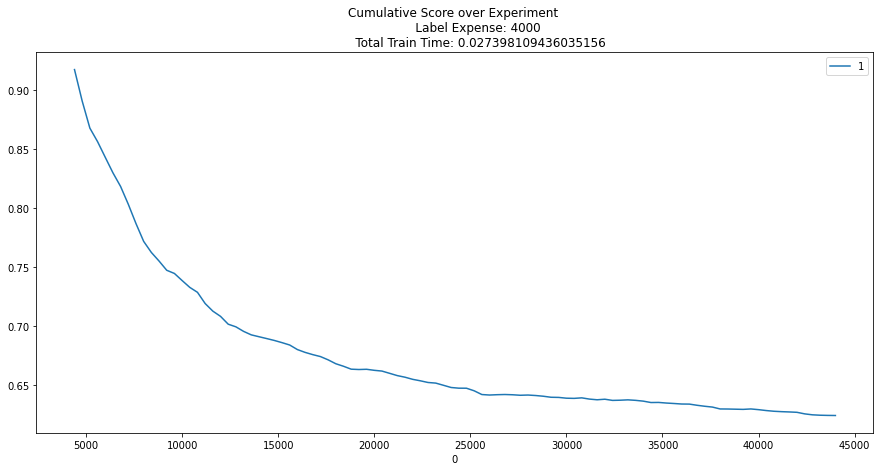

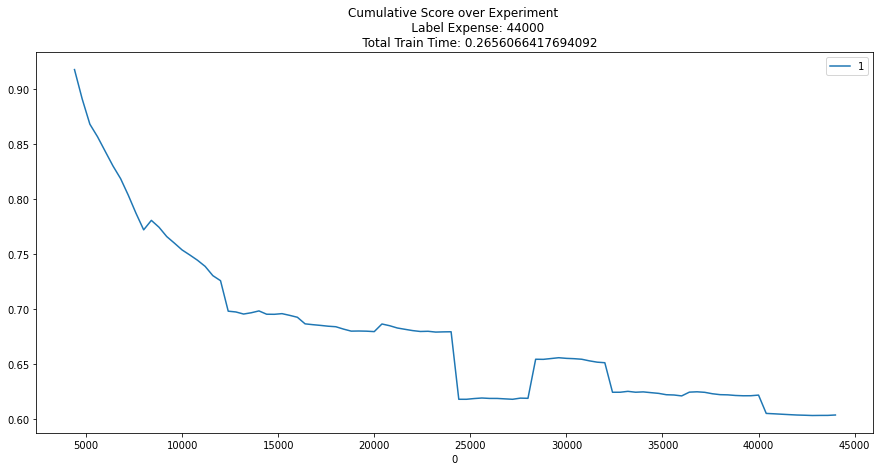

<IPython.core.display.Javascript object>

In [602]:
baseline_experiment.plot_error()
topline_experiment.plot_error()

### What happens if I use the other features...?
- VICdemand
- Transfer

In [388]:
# specify columns to keep and if categorical
cols = (
    ("day", True),
    ("period", True),
    ("nswdemand", False),
    ("vicdemand", False),
    ("transfer", False),
    ("class", True),
)

data_clean = data[[col for col, _ in cols]].copy(deep=True)

# label encode categorical
catcols = (col for col, iscat in cols if iscat)

for col in catcols:
    data_clean[col] = LabelEncoder().fit_transform(data_clean[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


data_clean = categorize(data_clean, cols)


<IPython.core.display.Javascript object>

In [390]:
data_clean

day period  nswdemand  vicdemand  transfer class
0       1      0   0.439155   0.422915  0.414912     1
1       1      1   0.415055   0.422915  0.414912     1
2       1      2   0.385004   0.422915  0.414912     1
3       1      3   0.314639   0.422915  0.414912     1
4       1      4   0.251116   0.422915  0.414912     0
...    ..    ...        ...        ...       ...   ...
45307   6     43   0.340672   0.255049  0.405263     0
45308   6     44   0.355549   0.241326  0.420614     0
45309   6     45   0.340970   0.247799  0.362281     0
45310   6     46   0.329366   0.345417  0.206579     1
45311   6     47   0.288753   0.355256  0.231140     0

[45312 rows x 6 columns]

<IPython.core.display.Javascript object>

0.9435294117647058


<AxesSubplot:xlabel='0'>

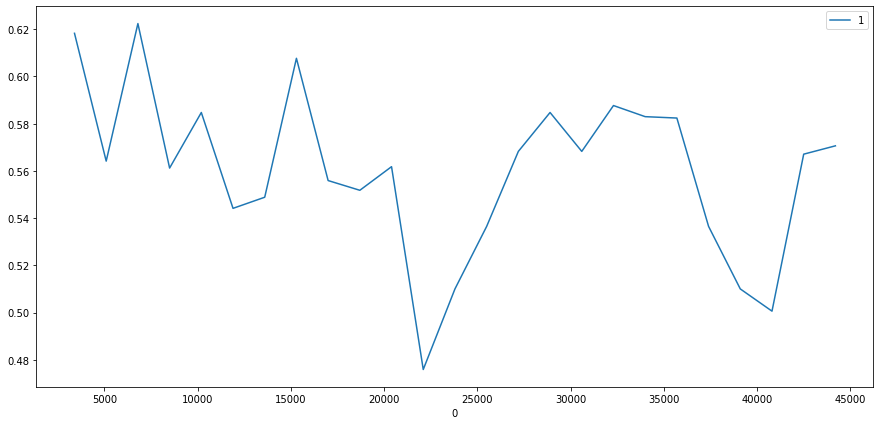

<IPython.core.display.Javascript object>

In [398]:
column_mapping = {
    "target": "class",
    "numerical_features": ["nswdemand", "vicdemand", "transfer"],
    "categorical_features": ["day", "period"],
}

ED_dataset = Dataset(
    full_df=data_clean, column_mapping=column_mapping, window_size=1700
)

exp = Experiment(
    model=RandomForestClassifier(n_estimators=5, random_state=42), dataset=ED_dataset
)

exp.run_baseline()

pd.DataFrame(exp.experiment_metrics["accuracy"]).set_index(0).plot(figsize=(15, 7))

**Questions for Nisha**
- Are they plotting cumulative accuracy?? Should we??
- Is it ok to use this dataset despite the flaws in features? Should we look to others... network intrusion, spam, etc?
- Chunk size is really important....
- Seasonality in data... should we correct it?
